1: Load the Dataset

target
1    357
0    212
Name: count, dtype: int64


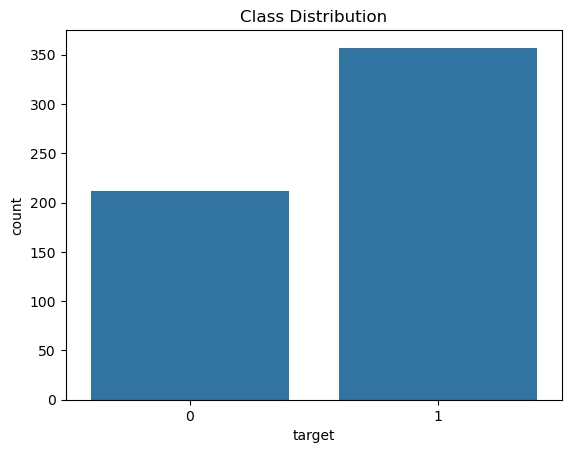

In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# Check class distribution
print(df['target'].value_counts())  # 0 = malignant, 1 = benign
sns.countplot(x='target', data=df)
plt.title("Class Distribution")
plt.savefig("class_distribution.png")
plt.show()

2. Simulate More Imbalance

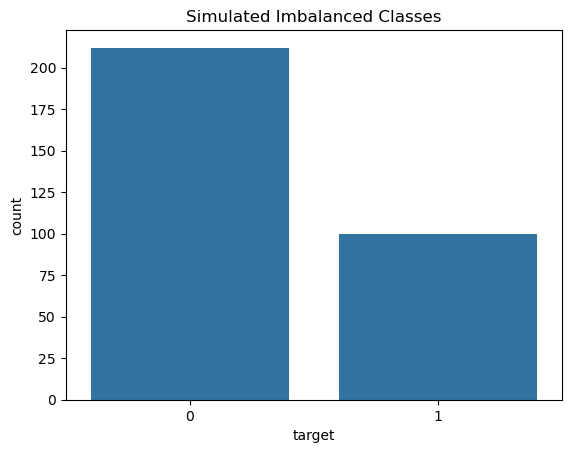

In [2]:
# Undersample class '1' to make it more imbalanced
df_minority = df[df['target'] == 0]
df_majority = df[df['target'] == 1].sample(n=100, random_state=42)

df = pd.concat([df_minority, df_majority])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

sns.countplot(x='target', data=df)
plt.title("Simulated Imbalanced Classes")
plt.savefig("imbalanced_distribution.png")
plt.show()

3. Train-Test Split

In [3]:
from sklearn.model_selection import train_test_split

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

4. Handle Imbalance with SMOTE

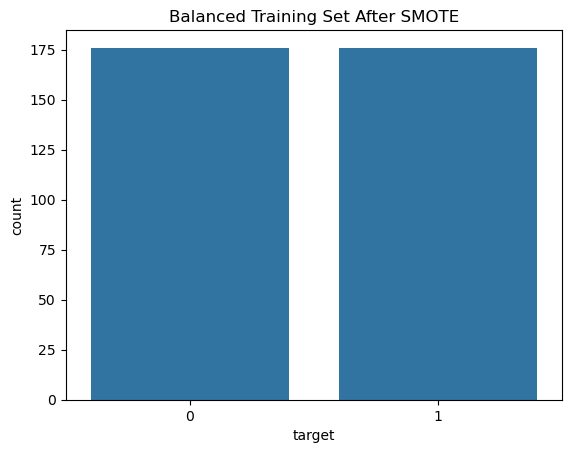

In [4]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Visualize new balance
sns.countplot(x=y_train_res)
plt.title("Balanced Training Set After SMOTE")
plt.savefig("smote_balanced_train.png")
plt.show()

5. Train Classifiers

( I ) Logistic Regression (with class_weight)

In [6]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(class_weight='balanced', max_iter=3000)
logreg.fit(X_train_res, y_train_res)

LogisticRegression(class_weight='balanced', max_iter=3000)

( II ) Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)

RandomForestClassifier(class_weight='balanced', random_state=42)

( III ) XGBoost

In [10]:
from xgboost import XGBClassifier

xgb = XGBClassifier(scale_pos_weight=1, eval_metric='logloss', random_state=42)
xgb.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

5. Evaluation Metrics


🔍 Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96        36
           1       0.93      0.96      0.95        27

    accuracy                           0.95        63
   macro avg       0.95      0.95      0.95        63
weighted avg       0.95      0.95      0.95        63



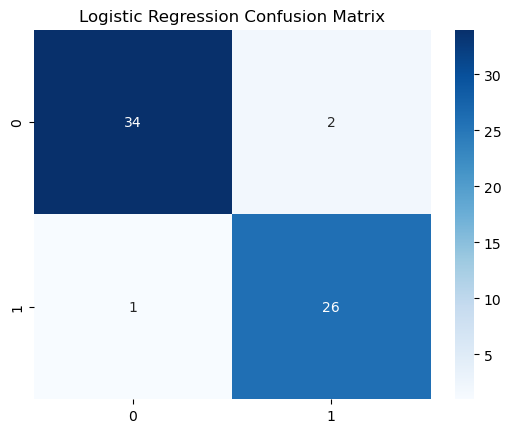

Logistic Regression ROC AUC: 0.9938

🔍 Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        36
           1       0.96      0.96      0.96        27

    accuracy                           0.97        63
   macro avg       0.97      0.97      0.97        63
weighted avg       0.97      0.97      0.97        63



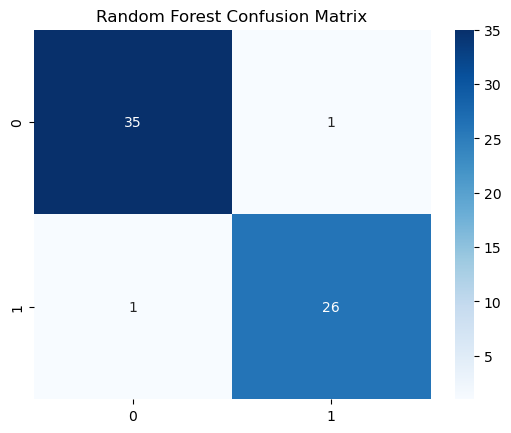

Random Forest ROC AUC: 0.9841

🔍 XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.96      1.00      0.98        27

    accuracy                           0.98        63
   macro avg       0.98      0.99      0.98        63
weighted avg       0.98      0.98      0.98        63



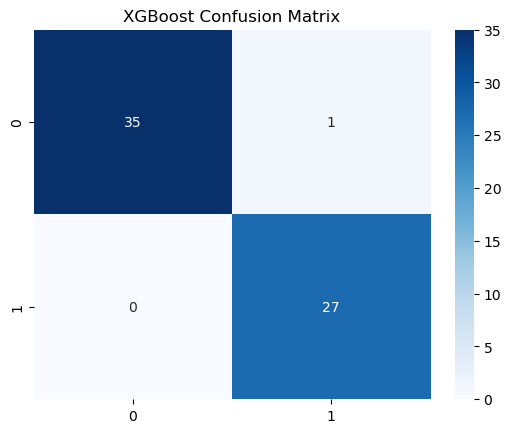

XGBoost ROC AUC: 0.9907


In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

def evaluate_model(model, X_test, y_test, name):
    print(f"\n🔍 {name} Classification Report:")
    preds = model.predict(X_test)
    print(classification_report(y_test, preds))

    # Confusion matrix
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.savefig(f"{name.lower().replace(' ', '_')}_confusion_matrix.png")
    plt.show()

    # ROC AUC
    probas = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, probas)
    print(f"{name} ROC AUC: {auc:.4f}")

evaluate_model(logreg, X_test, y_test, "Logistic Regression")
evaluate_model(rf, X_test, y_test, "Random Forest")
evaluate_model(xgb, X_test, y_test, "XGBoost")

6. Save Best Model

In [12]:
import joblib
joblib.dump(xgb, "best_classification_model.pkl")

['best_classification_model.pkl']